#**Практическое задание №1**

Установка необходимых пакетов:

In [1]:
!pip install -q tqdm
!pip install --upgrade --no-cache-dir gdown

Монтирование Вашего Google Drive к текущему окружению:

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Константы, которые пригодятся в коде далее, и ссылки (gdrive идентификаторы) на предоставляемые наборы данных:

In [3]:
EVALUATE_ONLY = True
TEST_ON_LARGE_DATASET = True
TISSUE_CLASSES = ('ADI', 'BACK', 'DEB', 'LYM', 'MUC', 'MUS', 'NORM', 'STR', 'TUM')
DATASETS_LINKS = {
    'train': '13rKbI2dwHTvpmP4r0ctj-FRmMD9QQdx5',
    'train_small': '1cd-cKWo408xs9P_1AYDemt3kfv6UUMnb',
    'train_tiny': '1vYJlVpI80QRc7xReAsc_D_VXWNjzZ3zc',
    'test': '1iHQse3D7r5-jxdqVhoavW2j_Q6OdQDq5',
    'test_small': '1DO4SY7l7ESlHEJuQAXVHBMzo_eYDWK-X',
    'test_tiny': '122LRP9arB7yH2NZX6zur28l_Gg2wHbyG'
}

Импорт необходимых зависимостей:

In [4]:
from pathlib import Path
import numpy as np
from typing import List
from tqdm.notebook import tqdm
from time import sleep
from PIL import Image
import IPython.display
from sklearn.metrics import balanced_accuracy_score
import gdown
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import albumentations as A
import torchvision.transforms as T
from sklearn.metrics import f1_score

# Константы для предобработки
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]
NETWORK_SIZE = (224, 224)

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


---
### Класс Dataset

Предназначен для работы с наборами данных, обеспечивает чтение изображений и соответствующих меток, а также формирование пакетов (батчей).

In [5]:
class Dataset:

    def __init__(self, name, train=False, num_classes=9):
        self.name = name
        self.is_loaded = False
        self.num_classes = num_classes
        url = f"https://drive.google.com/uc?export=download&confirm=pbef&id={DATASETS_LINKS[name]}"
        output = f'{name}.npz'
        gdown.download(url, output, quiet=False)
        print(f'Loading dataset {self.name} from npz.')
        np_obj = np.load(f'{name}.npz')
        self.images = np_obj['data']
        self.labels = np_obj['labels']
        self.n_files = self.images.shape[0]
        self.is_loaded = True
        print(f'Done. Dataset {name} consists of {self.n_files} images.')

        self.train = train

        # Для обучения и валидации применяем только Resize и Normalize без аугментаций
        self.transform = A.Compose([
            A.Resize(*NETWORK_SIZE),  # Изменение размера
            A.ToFloat(max_value=255),  # Конвертация в float
            A.Normalize(max_pixel_value=1.0, mean=IMAGENET_MEAN, std=IMAGENET_STD),  # Нормализация
        ])

        self.to_tensor = T.ToTensor()  # Преобразование в тензор отдельно

    def __getitem__(self, index):
        image, label = self.images[index], self.labels[index]

        # Применяем только нормализацию и изменение размера
        image = self.transform(image=image)['image']

        # Преобразуем изображение в тензор
        image = np.transpose(image, (2, 0, 1)) # Переставляем оси с (H, W, C) на (C, H, W)
        image = torch.from_numpy(image).float()  # Преобразуем в тензор

        return image, label

    def image(self, i):
        # read i-th image in dataset and return it as numpy array
        if self.is_loaded:
            return self.images[i, :, :, :]

    def __len__(self):
        return self.n_files

    def images_seq(self, n=None):
        # sequential access to images inside dataset (is needed for testing)
        for i in range(self.n_files if not n else n):
            yield self[i][0]

    def random_image_with_label(self):
        # get random image with label from dataset
        i = np.random.randint(self.n_files)
        return self.image(i), self.labels[i]

    def random_batch_with_labels(self, n):
        # create random batch of images with labels (is needed for training)
        indices = np.random.choice(self.n_files, n)
        imgs = []
        for i in indices:
            img = self.image(i)
            imgs.append(self.image(i))
        logits = np.array([self.labels[i] for i in indices])
        return np.stack(imgs), logits

    def image_with_label(self, i: int):
        # return i-th image with label from dataset
        return self.image(i), self.labels[i]

### Пример использвания класса Dataset
Загрузим обучающий набор данных, получим произвольное изображение с меткой. После чего визуализируем изображение, выведем метку. В будущем, этот кусок кода можно закомментировать или убрать.

Downloading...
From: https://drive.google.com/uc?export=download&confirm=pbef&id=1vYJlVpI80QRc7xReAsc_D_VXWNjzZ3zc
To: /content/train_tiny.npz
100%|██████████| 105M/105M [00:01<00:00, 75.6MB/s] 


Loading dataset train_tiny from npz.
Done. Dataset train_tiny consists of 900 images.

Got numpy array of shape (224, 224, 3), and label with code 0.
Label code corresponds to ADI class.


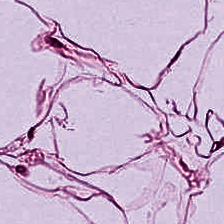

In [6]:
d_train_tiny = Dataset('train_tiny')

img, lbl = d_train_tiny.random_image_with_label()
print()
print(f'Got numpy array of shape {img.shape}, and label with code {lbl}.')
print(f'Label code corresponds to {TISSUE_CLASSES[lbl]} class.')

pil_img = Image.fromarray(img)
IPython.display.display(pil_img)

---
### Класс Metrics

Реализует метрики точности, используемые для оценивания модели:
1. точность,
2. сбалансированную точность.

In [7]:
class Metrics:

    @staticmethod
    def accuracy(gt: List[int], pred: List[int]):
        assert len(gt) == len(pred), 'gt and prediction should be of equal length'
        return sum(int(i[0] == i[1]) for i in zip(gt, pred)) / len(gt)

    @staticmethod
    def accuracy_balanced(gt: List[int], pred: List[int]):
        return balanced_accuracy_score(gt, pred)

    @staticmethod
    def print_all(gt: List[int], pred: List[int], info: str):
        print(f'metrics for {info}:')
        print('\t accuracy {:.4f}:'.format(Metrics.accuracy(gt, pred)))
        print('\t balanced accuracy {:.4f}:'.format(Metrics.accuracy_balanced(gt, pred)))

---
### Класс Model

Класс, хранящий в себе всю информацию о модели.

Вам необходимо реализовать методы save, load для сохранения и заргрузки модели. Особенно актуально это будет во время тестирования на дополнительных наборах данных.

> *Пожалуйста, убедитесь, что сохранение и загрузка модели работает корректно. Для этого обучите модель, протестируйте, сохраните ее в файл, перезапустите среду выполнения, загрузите обученную модель из файла, вновь протестируйте ее на тестовой выборке и убедитесь в том, что получаемые метрики совпадают с полученными для тестовой выбрки ранее.*


Также, Вы можете реализовать дополнительные функции, такие как:
1. валидацию модели на части обучающей выборки;
2. использование кроссвалидации;
3. автоматическое сохранение модели при обучении;
4. загрузку модели с какой-то конкретной итерации обучения (если используется итеративное обучение);
5. вывод различных показателей в процессе обучения (например, значение функции потерь на каждой эпохе);
6. построение графиков, визуализирующих процесс обучения (например, график зависимости функции потерь от номера эпохи обучения);
7. автоматическое тестирование на тестовом наборе/наборах данных после каждой эпохи обучения (при использовании итеративного обучения);
8. автоматический выбор гиперпараметров модели во время обучения;
9. сохранение и визуализацию результатов тестирования;
10. Использование аугментации и других способов синтетического расширения набора данных (дополнительным плюсом будет обоснование необходимости и обоснование выбора конкретных типов аугментации)
11. и т.д.

Полный список опций и дополнений приведен в презентации с описанием задания.

При реализации дополнительных функций допускается добавление параметров в существующие методы и добавление новых методов в класс модели.

In [24]:
from torchvision import models
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
from torchvision.models import ResNet50_Weights
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import os


class Model:
    def __init__(self, num_classes=9):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1).to(self.device)
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Linear(num_ftrs, num_classes).to(self.device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=0.0001)
        self.criterion = nn.CrossEntropyLoss()
    #LBL3
    def save(self, name: str):
        save_dir = '/content/drive/MyDrive/models'  # Path to the "models" folder

        # os.makedirs(save_dir, exist_ok=True)  # Create the directory if it doesn't exist

        save_path = os.path.join(save_dir, f'{name}.pth') # Full save path
        torch.save({
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
        }, save_path)
        print(f"Model saved to {save_path}")
    # LBL4
    def load(self, name: str):
        drive.mount('/content/drive', force_remount=True)  # Mount Google Drive
        load_dir = '/content/drive/MyDrive/models' # Path to models directory
        load_path = os.path.join(load_dir, f'{name}.pth') # Full load path

        try: # Add error handling
            checkpoint = torch.load(load_path, map_location=self.device)
            self.model.load_state_dict(checkpoint['model_state_dict'])
            self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            print(f"Model loaded from {load_path}")
        except FileNotFoundError:
            print(f"Error: Model file not found at {load_path}")
        except Exception as e: # Catch other potential errors
            print(f"An error occurred during model loading: {e}")

    def train(self, dataset, epochs=5, batch_size=16, val_split=0.2):
        self.history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [], 'val_f1': []}

        dataset_size = len(dataset)
        val_size = int(val_split * dataset_size)
        train_size = dataset_size - val_size
        #LBL1
        train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        self.model.train()  # Set model to training mode


        for epoch in range(epochs):
            running_loss = 0.0
            all_preds = []
            all_labels = []

            self.model.train()
            for imgs, labels in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs} - Training"):
                imgs = imgs.to(self.device)
                labels = labels.to(self.device)

                self.optimizer.zero_grad()
                outputs = self.model(imgs)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()

                running_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

            avg_loss = running_loss / len(train_loader)
            acc = accuracy_score(all_labels, all_preds)
            f1 = f1_score(all_labels, all_preds, average='weighted')
            self.history['train_loss'].append(avg_loss)
            self.history['train_acc'].append(acc)

            # Validation
            self.model.eval()
            val_loss = 0.0
            val_preds = []
            val_labels = []

            with torch.no_grad():
                for imgs, labels in tqdm(val_loader, desc=f"Epoch {epoch + 1}/{epochs} - Validation"):
                    imgs = imgs.to(self.device)
                    labels = labels.to(self.device)
                    outputs = self.model(imgs)
                    loss = self.criterion(outputs, labels)
                    val_loss += loss.item()
                    _, predicted = torch.max(outputs, 1)
                    val_preds.extend(predicted.cpu().numpy())
                    val_labels.extend(labels.cpu().numpy())

            avg_val_loss = val_loss / len(val_loader)
            val_acc = accuracy_score(val_labels, val_preds)
            val_f1 = f1_score(val_labels, val_preds, average='weighted')
            self.history['val_loss'].append(avg_val_loss)
            self.history['val_acc'].append(val_acc)
            self.history['val_f1'].append(val_f1)
            #LBL5
            print(f"Epoch [{epoch+1}/{epochs}], "
                  f"Train Loss: {avg_loss:.4f}, Train Acc: {acc:.4f}, Train F1: {f1:.4f}, "
                  f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.4f}, Val F1: {val_f1:.4f}")
            self.save(f'model_epoch_{epoch + 1}.pt')

        self.plot_history()
    #LBL6
    def plot_history(self):
        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.plot(self.history['train_loss'], label='Train Loss')
        plt.plot(self.history['val_loss'], label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.title('Training and Validation Loss')

        plt.subplot(1, 2, 2)
        plt.plot(self.history['train_acc'], label='Train Accuracy')
        plt.plot(self.history['val_acc'], label='Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.title('Training and Validation Accuracy')

        plt.tight_layout()
        plt.show()

    def test_on_dataset(self, dataset: Dataset, limit=None):
      self.model.eval()
      predictions = []
      n = dataset.n_files if not limit else int(dataset.n_files * limit)

      with torch.no_grad():
          for img in tqdm(dataset.images_seq(n), total=n):
              #print(img.shape)
              predictions.append(self.test_on_image(img))
      return predictions

    def test_on_image(self, img: np.ndarray):
        img = img.unsqueeze(0).to(self.device)
        # img = img.permute(0, 3, 1, 2)
        output = self.model(img)
        prediction = torch.argmax(output).item()
        return prediction



In [9]:
train_dataset = Dataset("train", train=False)  # Аугментации для обучения


Downloading...
From: https://drive.google.com/uc?export=download&confirm=pbef&id=13rKbI2dwHTvpmP4r0ctj-FRmMD9QQdx5
To: /content/train.npz
100%|██████████| 2.10G/2.10G [00:29<00:00, 70.3MB/s]


Loading dataset train from npz.
Done. Dataset train consists of 18000 images.


Epoch 1/10 - Training:   0%|          | 0/450 [00:00<?, ?it/s]

Epoch 1/10 - Validation:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch [1/10], Train Loss: 0.1991, Train Acc: 0.9383, Train F1: 0.9383, Val Loss: 0.0972, Val Acc: 0.9689, Val F1: 0.9690
Model saved to /content/drive/MyDrive/models/model_epoch_1.pt.pth


Epoch 2/10 - Training:   0%|          | 0/450 [00:00<?, ?it/s]

Epoch 2/10 - Validation:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch [2/10], Train Loss: 0.0632, Train Acc: 0.9805, Train F1: 0.9805, Val Loss: 0.0590, Val Acc: 0.9806, Val F1: 0.9806
Model saved to /content/drive/MyDrive/models/model_epoch_2.pt.pth


Epoch 3/10 - Training:   0%|          | 0/450 [00:00<?, ?it/s]

Epoch 3/10 - Validation:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch [3/10], Train Loss: 0.0484, Train Acc: 0.9845, Train F1: 0.9845, Val Loss: 0.0651, Val Acc: 0.9808, Val F1: 0.9809
Model saved to /content/drive/MyDrive/models/model_epoch_3.pt.pth


Epoch 4/10 - Training:   0%|          | 0/450 [00:00<?, ?it/s]

Epoch 4/10 - Validation:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch [4/10], Train Loss: 0.0427, Train Acc: 0.9860, Train F1: 0.9860, Val Loss: 0.0525, Val Acc: 0.9836, Val F1: 0.9836
Model saved to /content/drive/MyDrive/models/model_epoch_4.pt.pth


Epoch 5/10 - Training:   0%|          | 0/450 [00:00<?, ?it/s]

Epoch 5/10 - Validation:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch [5/10], Train Loss: 0.0303, Train Acc: 0.9911, Train F1: 0.9911, Val Loss: 0.0477, Val Acc: 0.9847, Val F1: 0.9847
Model saved to /content/drive/MyDrive/models/model_epoch_5.pt.pth


Epoch 6/10 - Training:   0%|          | 0/450 [00:00<?, ?it/s]

Epoch 6/10 - Validation:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch [6/10], Train Loss: 0.0325, Train Acc: 0.9903, Train F1: 0.9903, Val Loss: 0.0514, Val Acc: 0.9869, Val F1: 0.9870
Model saved to /content/drive/MyDrive/models/model_epoch_6.pt.pth


Epoch 7/10 - Training:   0%|          | 0/450 [00:00<?, ?it/s]

Epoch 7/10 - Validation:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch [7/10], Train Loss: 0.0201, Train Acc: 0.9940, Train F1: 0.9940, Val Loss: 0.0974, Val Acc: 0.9756, Val F1: 0.9756
Model saved to /content/drive/MyDrive/models/model_epoch_7.pt.pth


Epoch 8/10 - Training:   0%|          | 0/450 [00:00<?, ?it/s]

Epoch 8/10 - Validation:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch [8/10], Train Loss: 0.0321, Train Acc: 0.9912, Train F1: 0.9912, Val Loss: 0.0493, Val Acc: 0.9856, Val F1: 0.9855
Model saved to /content/drive/MyDrive/models/model_epoch_8.pt.pth


Epoch 9/10 - Training:   0%|          | 0/450 [00:00<?, ?it/s]

Epoch 9/10 - Validation:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch [9/10], Train Loss: 0.0155, Train Acc: 0.9949, Train F1: 0.9949, Val Loss: 0.0559, Val Acc: 0.9853, Val F1: 0.9853
Model saved to /content/drive/MyDrive/models/model_epoch_9.pt.pth


Epoch 10/10 - Training:   0%|          | 0/450 [00:00<?, ?it/s]

Epoch 10/10 - Validation:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch [10/10], Train Loss: 0.0189, Train Acc: 0.9948, Train F1: 0.9948, Val Loss: 0.0643, Val Acc: 0.9800, Val F1: 0.9799
Model saved to /content/drive/MyDrive/models/model_epoch_10.pt.pth


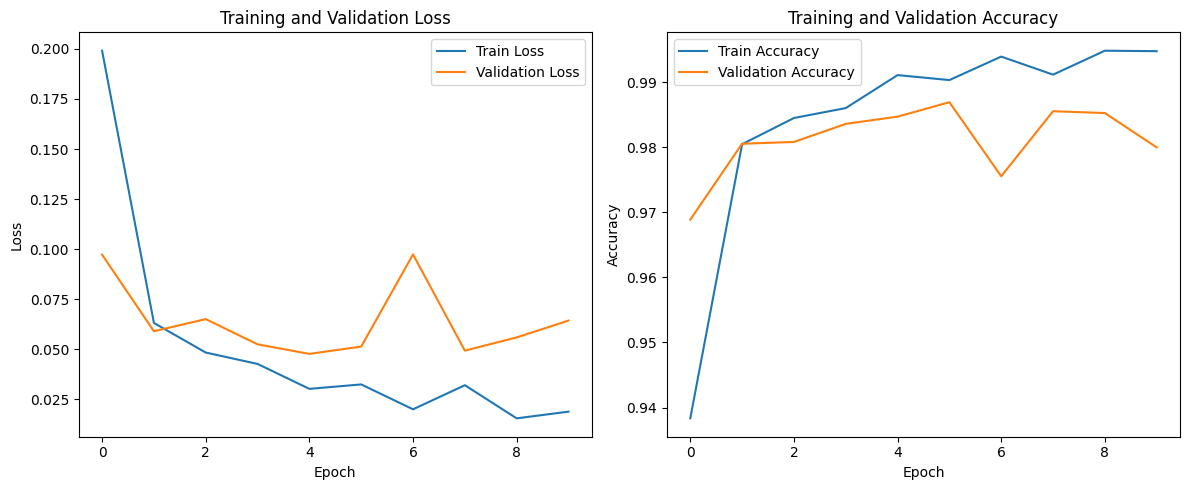

Model saved to /content/drive/MyDrive/models/best.pth


In [12]:
model = Model()
model.train(train_dataset, epochs=10, batch_size=32)
model.save('best')
# model.load('best')

In [13]:
test_dataset = Dataset("test", train=False, num_classes=9)

Downloading...
From: https://drive.google.com/uc?export=download&confirm=pbef&id=1iHQse3D7r5-jxdqVhoavW2j_Q6OdQDq5
To: /content/test.npz
100%|██████████| 525M/525M [00:04<00:00, 109MB/s]


Loading dataset test from npz.
Done. Dataset test consists of 4500 images.


In [17]:
# test_dataset = Dataset("test_dataset_name", train=False, num_classes=9) # Replace "test_dataset_name"
from sklearn.metrics import accuracy_score
# Perform testintg and get predictions
model.load('best')
predictions = model.test_on_dataset(test_dataset)

# Assuming 'test_dataset' has a method to get all labels
true_labels = test_dataset.labels # Get true labels from the test dataset

# Calculate accuracy
accuracy_ = accuracy_score(true_labels, predictions)

# Calculate weighted F1-score
f1 = f1_score(true_labels, predictions, average='weighted')



print(f"Test Accuracy: {accuracy_:.4f}")
print(f"Test Weighted F1-score: {f1:.4f}")

Mounted at /content/drive
Error: Model file not found at /content/drive/MyDrive/models_new/best.pth


<ipython-input-11-a5e85d56b25f>:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(load_path, map_location=self.device)


  0%|          | 0/4500 [00:00<?, ?it/s]

Test Accuracy: 0.9822
Test Weighted F1-score: 0.9822


---
### Классификация изображений

Используя введенные выше классы можем перейти уже непосредственно к обучению модели классификации изображений. Пример общего пайплайна решения задачи приведен ниже. Вы можете его расширять и улучшать. В данном примере используются наборы данных 'train_small' и 'test_small'.

In [18]:
d_train = Dataset('train_small')
d_test = Dataset('test_small')

Downloading...
From: https://drive.google.com/uc?export=download&confirm=pbef&id=1cd-cKWo408xs9P_1AYDemt3kfv6UUMnb
To: /content/train_small.npz
100%|██████████| 841M/841M [00:10<00:00, 78.5MB/s]


Loading dataset train_small from npz.
Done. Dataset train_small consists of 7200 images.


Downloading...
From: https://drive.google.com/uc?export=download&confirm=pbef&id=1DO4SY7l7ESlHEJuQAXVHBMzo_eYDWK-X
To: /content/test_small.npz
100%|██████████| 211M/211M [00:01<00:00, 186MB/s]


Loading dataset test_small from npz.
Done. Dataset test_small consists of 1800 images.


In [19]:
model = Model()
if not EVALUATE_ONLY:
    model.train(d_train)
    model.save('best')
else:
    #todo: your link goes here
    model.load('best')

Mounted at /content/drive


<ipython-input-15-0e0314ee80cb>:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(load_path, map_location=self.device)


Model loaded from /content/drive/MyDrive/models/best.pth


Пример тестирования модели на части набора данных:

In [20]:
# evaluating model on 10% of test dataset
pred_1 = model.test_on_dataset(d_test, limit=0.1)
Metrics.print_all(d_test.labels[:len(pred_1)], pred_1, '10% of test')

  0%|          | 0/180 [00:00<?, ?it/s]

metrics for 10% of test:
	 accuracy 1.0000:
	 balanced accuracy 1.0000:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


Пример тестирования модели на полном наборе данных:

In [21]:
# evaluating model on full test dataset (may take time)
if TEST_ON_LARGE_DATASET:
    pred_2 = model.test_on_dataset(d_test)
    Metrics.print_all(d_test.labels, pred_2, 'test')

  0%|          | 0/1800 [00:00<?, ?it/s]

metrics for test:
	 accuracy 0.9811:
	 balanced accuracy 0.9811:


Результат работы пайплайна обучения и тестирования выше тоже будет оцениваться. Поэтому не забудьте присылать на проверку ноутбук с выполнеными ячейками кода с демонстрациями метрик обучения, графиками и т.п. В этом пайплайне Вам необходимо продемонстрировать работу всех реализованных дополнений, улучшений и т.п.

<font color="red">
Настоятельно рекомендуется после получения пайплайна с полными результатами обучения экспортировать ноутбук в pdf (файл -> печать) и прислать этот pdf вместе с самим ноутбуком.
</font>

### Тестирование модели на других наборах данных

Ваша модель должна поддерживать тестирование на других наборах данных. Для удобства, Вам предоставляется набор данных test_tiny, который представляет собой малую часть (2% изображений) набора test. Ниже приведен фрагмент кода, который будет осуществлять тестирование для оценивания Вашей модели на дополнительных тестовых наборах данных.

<font color="red">
Прежде чем отсылать задание на проверку, убедитесь в работоспособности фрагмента кода ниже.
</font>

In [22]:
final_model = Model()
final_model.load('best')
d_test_tiny = Dataset('test_tiny')
pred = model.test_on_dataset(d_test_tiny)
Metrics.print_all(d_test_tiny.labels, pred, 'test-tiny')

Mounted at /content/drive


<ipython-input-15-0e0314ee80cb>:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(load_path, map_location=self.device)


Model loaded from /content/drive/MyDrive/models/best.pth


Downloading...
From: https://drive.google.com/uc?export=download&confirm=pbef&id=122LRP9arB7yH2NZX6zur28l_Gg2wHbyG
To: /content/test_tiny.npz
100%|██████████| 10.6M/10.6M [00:00<00:00, 68.1MB/s]


Loading dataset test_tiny from npz.
Done. Dataset test_tiny consists of 90 images.


  0%|          | 0/90 [00:00<?, ?it/s]

metrics for test-tiny:
	 accuracy 0.9778:
	 balanced accuracy 0.9778:


Отмонтировать Google Drive.

In [23]:
drive.flush_and_unmount()

---
# Дополнительные "полезности"

Ниже приведены примеры использования различных функций и библиотек, которые могут быть полезны при выполнении данного практического задания.

### Измерение времени работы кода

Измерять время работы какой-либо функции можно легко и непринужденно при помощи функции timeit из соответствующего модуля:

In [ ]:
import timeit

def factorial(n):
    res = 1
    for i in range(1, n + 1):
        res *= i
    return res


def f():
    return factorial(n=1000)

n_runs = 128
print(f'Function f is caluclated {n_runs} times in {timeit.timeit(f, number=n_runs)}s.')

### Scikit-learn

Для использования "классических" алгоритмов машинного обучения рекомендуется использовать библиотеку scikit-learn (https://scikit-learn.org/stable/). Пример классификации изображений цифр из набора данных MNIST при помощи классификатора SVM:

In [ ]:
# Standard scientific Python imports
import matplotlib.pyplot as plt

# Import datasets, classifiers and performance metrics
from sklearn import datasets, svm, metrics
from sklearn.model_selection import train_test_split

# The digits dataset
digits = datasets.load_digits()

# The data that we are interested in is made of 8x8 images of digits, let's
# have a look at the first 4 images, stored in the `images` attribute of the
# dataset.  If we were working from image files, we could load them using
# matplotlib.pyplot.imread.  Note that each image must have the same size. For these
# images, we know which digit they represent: it is given in the 'target' of
# the dataset.
_, axes = plt.subplots(2, 4)
images_and_labels = list(zip(digits.images, digits.target))
for ax, (image, label) in zip(axes[0, :], images_and_labels[:4]):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title('Training: %i' % label)

# To apply a classifier on this data, we need to flatten the image, to
# turn the data in a (samples, feature) matrix:
n_samples = len(digits.images)
data = digits.images.reshape((n_samples, -1))

# Create a classifier: a support vector classifier
classifier = svm.SVC(gamma=0.001)

# Split data into train and test subsets
X_train, X_test, y_train, y_test = train_test_split(
    data, digits.target, test_size=0.5, shuffle=False)

# We learn the digits on the first half of the digits
classifier.fit(X_train, y_train)

# Now predict the value of the digit on the second half:
predicted = classifier.predict(X_test)

images_and_predictions = list(zip(digits.images[n_samples // 2:], predicted))
for ax, (image, prediction) in zip(axes[1, :], images_and_predictions[:4]):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title('Prediction: %i' % prediction)

print("Classification report for classifier %s:\n%s\n"
      % (classifier, metrics.classification_report(y_test, predicted)))
disp = metrics.plot_confusion_matrix(classifier, X_test, y_test)
disp.figure_.suptitle("Confusion Matrix")
print("Confusion matrix:\n%s" % disp.confusion_matrix)

plt.show()

### Scikit-image

Реализовывать различные операции для работы с изображениями можно как самостоятельно, работая с массивами numpy, так и используя специализированные библиотеки, например, scikit-image (https://scikit-image.org/). Ниже приведен пример использования Canny edge detector.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi

from skimage import feature


# Generate noisy image of a square
im = np.zeros((128, 128))
im[32:-32, 32:-32] = 1

im = ndi.rotate(im, 15, mode='constant')
im = ndi.gaussian_filter(im, 4)
im += 0.2 * np.random.random(im.shape)

# Compute the Canny filter for two values of sigma
edges1 = feature.canny(im)
edges2 = feature.canny(im, sigma=3)

# display results
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(8, 3),
                                    sharex=True, sharey=True)

ax1.imshow(im, cmap=plt.cm.gray)
ax1.axis('off')
ax1.set_title('noisy image', fontsize=20)

ax2.imshow(edges1, cmap=plt.cm.gray)
ax2.axis('off')
ax2.set_title(r'Canny filter, $\sigma=1$', fontsize=20)

ax3.imshow(edges2, cmap=plt.cm.gray)
ax3.axis('off')
ax3.set_title(r'Canny filter, $\sigma=3$', fontsize=20)

fig.tight_layout()

plt.show()

### Tensorflow 2

Для создания и обучения нейросетевых моделей можно использовать фреймворк глубокого обучения Tensorflow 2. Ниже приведен пример простейшей нейроной сети, использующейся для классификации изображений из набора данных MNIST.

In [ ]:
# Install TensorFlow

import tensorflow as tf

mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(x_train, y_train, epochs=5)

model.evaluate(x_test,  y_test, verbose=2)

<font color="red">
Для эффективной работы с моделями глубокого обучения убедитесь в том, что в текущей среде Google Colab используется аппаратный ускоритель GPU или TPU. Для смены среды выберите "среда выполнения" -> "сменить среду выполнения".
</font>

Большое количество туториалов и примеров с кодом на Tensorflow 2 можно найти на официальном сайте https://www.tensorflow.org/tutorials?hl=ru.

Также, Вам может понадобиться написать собственный генератор данных для Tensorflow 2. Скорее всего он будет достаточно простым, и его легко можно будет реализовать, используя официальную документацию TensorFlow 2. Но, на всякий случай (если не удлось сразу разобраться или хочется вникнуть в тему более глубоко), можете посмотреть следующий отличный туториал: https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly.

### Numba

В некоторых ситуациях, при ручных реализациях графовых алгоритмов, выполнение многократных вложенных циклов for в python можно существенно ускорить, используя JIT-компилятор Numba (https://numba.pydata.org/).
Примеры использования Numba в Google Colab можно найти тут:
1. https://colab.research.google.com/github/cbernet/maldives/blob/master/numba/numba_cuda.ipynb
2. https://colab.research.google.com/github/evaneschneider/parallel-programming/blob/master/COMPASS_gpu_intro.ipynb

> Пожалуйста, если Вы решили использовать Numba для решения этого практического задания, еще раз подумайте, нужно ли это Вам, и есть ли возможность реализовать требуемую функциональность иным способом. Используйте Numba только при реальной необходимости.



### Работа с zip архивами в Google Drive

Запаковка и распаковка zip архивов может пригодиться при сохранении и загрузки Вашей модели. Ниже приведен фрагмент кода, иллюстрирующий помещение нескольких файлов в zip архив с последующим чтением файлов из него. Все действия с директориями, файлами и архивами должны осущетвляться с примонтированным Google Drive.


Создадим 2 изображения, поместим их в директорию tmp внутри PROJECT_DIR, запакуем директорию tmp в архив tmp.zip.

In [ ]:
PROJECT_DIR = "/dev/prak_nn_1/"
arr1 = np.random.rand(100, 100, 3) * 255
arr2 = np.random.rand(100, 100, 3) * 255

img1 = Image.fromarray(arr1.astype('uint8'))
img2 = Image.fromarray(arr2.astype('uint8'))

p = "/content/drive/MyDrive/" + PROJECT_DIR

if not (Path(p) / 'tmp').exists():
    (Path(p) / 'tmp').mkdir()

img1.save(str(Path(p) / 'tmp' / 'img1.png'))
img2.save(str(Path(p) / 'tmp' / 'img2.png'))

%cd $p
!zip -r "tmp.zip" "tmp"

Распакуем архив tmp.zip в директорию tmp2 в PROJECT_DIR. Теперь внутри директории tmp2 содержится директория tmp, внутри которой находятся 2 изображения.

In [ ]:
p = "/content/drive/MyDrive/" + PROJECT_DIR
%cd $p
!unzip -uq "tmp.zip" -d "tmp2"